# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)

# Load Data

In [3]:
df = pd.read_csv('data/M1_final.csv')
df_0 = df.copy()

# Clean Dataset

## Drop NaN

In [4]:
print(df.shape)
df = df.dropna(axis=0)
print(df.shape)

(28820, 23)
(28818, 23)


## Dtype

In [12]:
df['Dew Point'].unique()

array(['34', '32', '33', '31', '30', '29', '67', '35', '36', '38', '39',
       '40', '41', '42', '28', '27', '46', '37', '44', '45', '52', '53',
       '54', '56', '57', '59', '58', '50', '43', '48', '49', '47', '21',
       '20', '22', '24', '23', '19', '18', '16', '13', '12', '14', '15',
       '17', '26', '25', '51', '55', '6\xa0', '9\xa0', '5\xa0', '8\xa0',
       '10', '4\xa0', '7\xa0', '3\xa0', '2\xa0', '11', '0\xa0', '-1',
       '1\xa0', '-2', '-3'], dtype=object)

In [19]:
df['Dew Point'] = df['Dew Point'].apply(lambda r : r.split()[0])

In [22]:
df['Dew Point'] = pd.to_numeric(df['Dew Point'])

## Numerical cols

In [24]:
df_num = df.loc[:, df.dtypes != np.object]
df_num.shape

(28818, 18)

## Categorical cols

In [25]:
df_cat = df.loc[:, df.dtypes == np.object]
df_cat.shape

(28818, 5)

# Machine Learning

In [30]:
from sklearn.model_selection import train_test_split

X = df.drop('TAXI_OUT', axis=1)
y = df['TAXI_OUT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## 1) Feature Selection

### a) Numeric

In [81]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler


def model_run_cv(cols, X, y):
    
    scaler = StandardScaler()
    X_scale = scaler.fit_transform(X[cols])
    y_scale = scaler.fit_transform(np.array(y).reshape(-1,1))
    
    estimator = DecisionTreeRegressor()    
    scr = cross_val_score(estimator, X_scale, y_scale, cv=5).mean()
    print('score = {:.0%}'.format(scr))
    
    y_pred = cross_val_predict(estimator, X_scale, y_scale, cv=5)
    plt.scatter(y_scale, y_pred)
    plt.show();

In [61]:
df_num.head(3)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_M,DEP_TIME_M,CRS_ARR_M,Temperature,Dew Point,Humidity,Wind Speed,Wind Gust,Pressure,sch_dep,sch_arr,TAXI_OUT
0,11,1,5,-1,124,636,324,323,448,48,34,58,25,38,29.86,9,17,14
1,11,1,5,-7,371,2475,340,333,531,48,34,58,25,38,29.86,9,17,15
2,11,1,5,40,181,1069,301,341,482,48,34,58,25,38,29.86,9,17,22


score = 22%


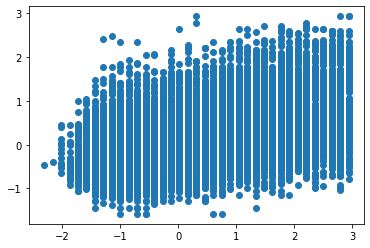

In [82]:
cols = ['Temperature', 'Humidity', 'Wind Speed', 'Wind Gust', 'Pressure']

model_run_cv(cols, X_train, y_train)

score = 22%


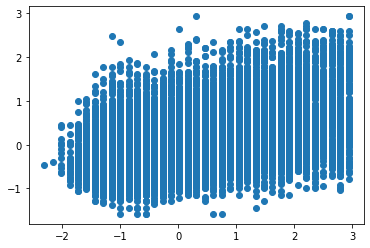

In [83]:
cols = ['Humidity', 'Dew Point', 'Wind Speed', 'Wind Gust', 'Pressure', 'MONTH']

model_run_cv(cols, X_train, y_train)

score = 23%


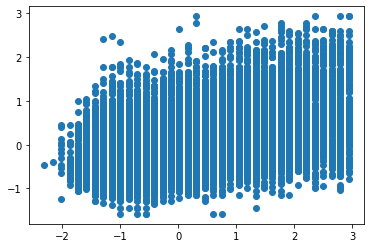

In [84]:
cols = ['Humidity', 'Dew Point', 'Wind Speed', 'Wind Gust', 'Pressure', 'DAY_OF_MONTH']

model_run_cv(cols, X_train, y_train)

score = 22%


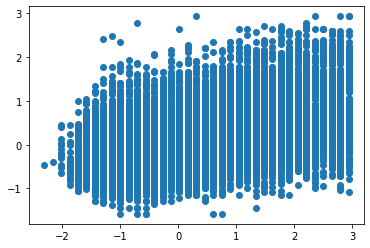

In [87]:
cols = ['Humidity', 'Dew Point', 'Wind Speed', 'Wind Gust', 'Pressure', 'DAY_OF_WEEK']

model_run_cv(cols, X_train, y_train)

score = -13%


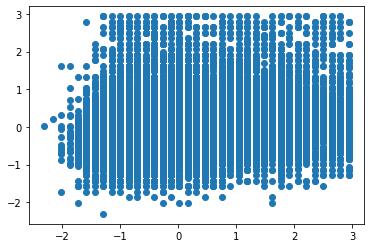

In [96]:
cols = ['CRS_ELAPSED_TIME', 'CRS_ARR_M', 'Wind Gust']

model_run_cv(cols, X_train, y_train)

In [97]:
num_cols = ['Humidity', 'Dew Point', 'Wind Speed', 'Wind Gust', 'Pressure', 'DAY_OF_MONTH']

### b) Categorical

In [99]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


def model_run_cv_cat(cols, X, y):
    
    transformer = OneHotEncoder()
    scaler = StandardScaler()
    X_scale = transformer.fit_transform(X[cols])
    y_scale = scaler.fit_transform(np.array(y).reshape(-1,1))
    print(X_scale.shape)
    
    estimator = DecisionTreeRegressor()    
    scr = cross_val_score(estimator, X_scale, y_scale, cv=5).mean()
    print('score = {:.0%}'.format(scr))
    
    y_pred = cross_val_predict(estimator, X_scale, y_scale, cv=5)
    plt.scatter(y_scale, y_pred)
    plt.show();

(25936, 9)
score = 3%


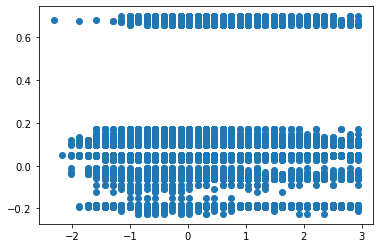

In [101]:
cols = ['OP_UNIQUE_CARRIER']

model_run_cv_cat(cols, X_train, y_train)

(25936, 52)
score = 5%


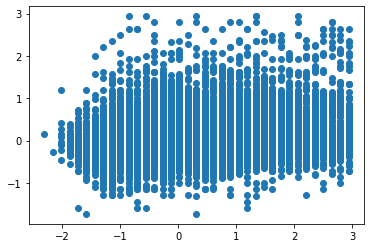

In [102]:
cols = ['Condition', 'OP_UNIQUE_CARRIER', 'Wind']

model_run_cv_cat(cols, X_train, y_train)

In [103]:
cat_cols = ['Condition', 'OP_UNIQUE_CARRIER', 'Wind']

## 2) Preprocessing

In [107]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

def crossVal_model(numerical_features, categorical_features, estimator, X_train, y_train):
    
    #preprocessing
    numerical_pipeline = make_pipeline(SimpleImputer(), StandardScaler())
    categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown = "ignore"))

    preprocessor = make_column_transformer((numerical_pipeline, numerical_features), 
                                           (categorical_pipeline, categorical_features))
    
    #model
    model = make_pipeline(preprocessor, estimator)
    
    #cross validation
    scr = cross_val_score(model, X_train, y_train, cv=5).mean()
    print('score = {:.0%}'.format(scr))
    
    #plot
    y_pred = cross_val_predict(model, X_train, y_train, cv=5)
    plt.scatter(y_train, y_pred)
    plt.show();

## 3) Model

### a) features selection

score = 3%


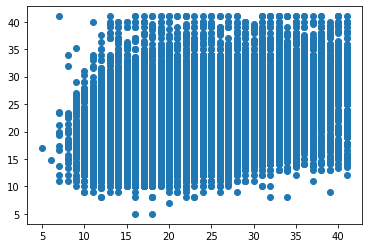

In [105]:
estimator = DecisionTreeRegressor()

crossVal_model(num_cols, cat_cols, estimator, X_train, y_train)

score = 21%


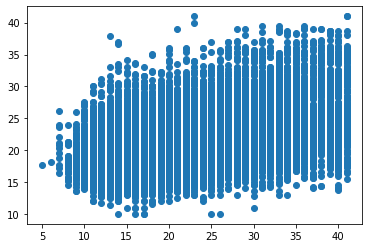

In [111]:
num_cols = ['Humidity', 'Pressure']
cat_cols = ['Wind']
estimator = DecisionTreeRegressor()

crossVal_model(num_cols, cat_cols, estimator, X_train, y_train)

score = 22%


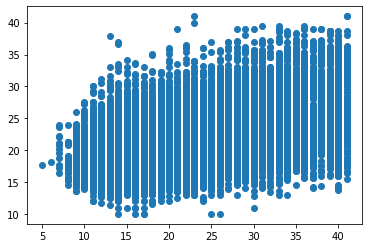

In [112]:
num_cols = ['Humidity', 'Pressure', 'Wind Gust']
cat_cols = ['Wind']
estimator = DecisionTreeRegressor()

crossVal_model(num_cols, cat_cols, estimator, X_train, y_train)

score = 22%


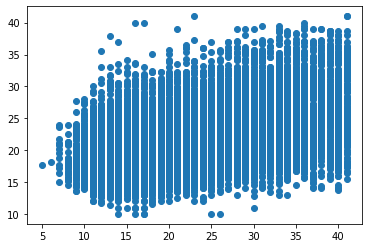

In [119]:
num_cols = ['Humidity', 'Pressure', 'Wind Speed', 'Temperature', 'DAY_OF_WEEK', 'DAY_OF_MONTH']
cat_cols = ['Wind', 'Condition']
estimator = DecisionTreeRegressor()

crossVal_model(num_cols, cat_cols, estimator, X_train, y_train)

score = 22%


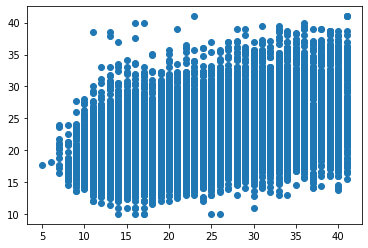

In [136]:
num_cols = ['Wind Speed', 'Wind Gust', 'Pressure', 'Humidity']
cat_cols = ['Wind', 'Condition']
estimator = DecisionTreeRegressor()

crossVal_model(num_cols, cat_cols, estimator, X_train, y_train)

### b) Models Selection

In [137]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

reg = LinearRegression()
ridge = Ridge()
lasso = Lasso()
knn = KNeighborsRegressor()
svr = SVR()
tree = DecisionTreeRegressor()



list_estimators = [reg, ridge, lasso, knn, svr, tree]

score = 4%


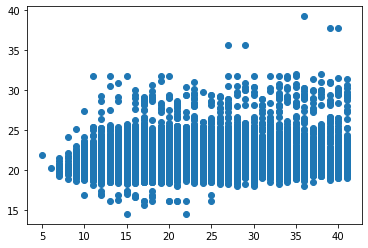

score = 4%


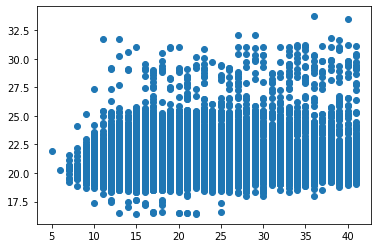

score = -0%


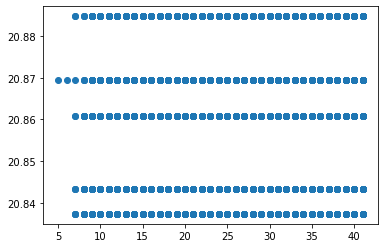

score = 14%


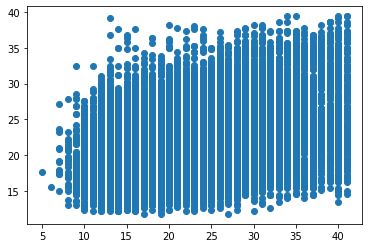

score = 7%


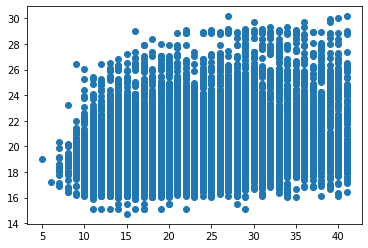

score = 22%


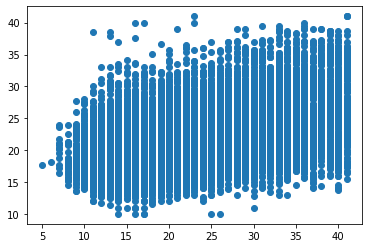

In [138]:
num_cols = ['Wind Speed', 'Wind Gust', 'Pressure', 'Humidity']
cat_cols = ['Wind', 'Condition']

for estimator in list_estimators:
    crossVal_model(num_cols, cat_cols, estimator, X_train, y_train)

score = 1%


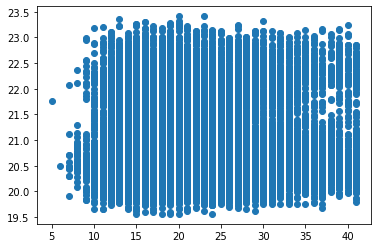

score = 1%


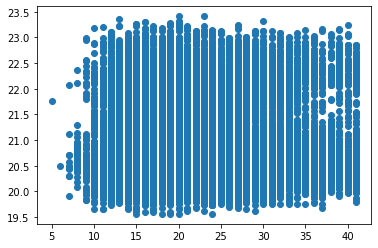

score = -0%


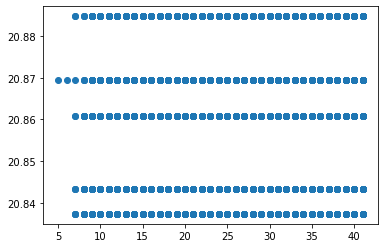

score = 14%


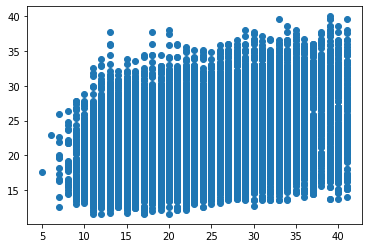

score = 1%


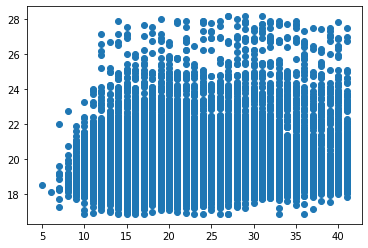

score = 22%


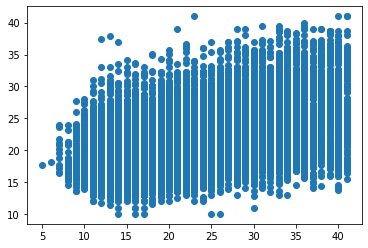

In [139]:
num_cols = ['Wind Speed', 'Wind Gust', 'Pressure', 'Humidity']
cat_cols = []

for estimator in list_estimators:
    crossVal_model(num_cols, cat_cols, estimator, X_train, y_train)

### c) Model Optimization

In [140]:
from sklearn.tree import DecisionTreeRegressor

estimator = DecisionTreeRegressor()

score = 22%


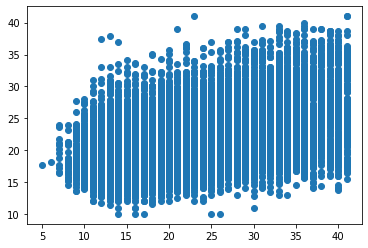

In [141]:
num_cols = ['Wind Speed', 'Wind Gust', 'Pressure', 'Humidity']
cat_cols = []

crossVal_model(num_cols, cat_cols, estimator, X_train, y_train)